# Preliminary assessment of Plane of Array irradiance measurements
NOTE: python 3.7 installed locally, remote version  Python 3.7.7 on console?
**BEWARE** all precise locations to be masked even in folder path
<!--
[Python releases status](https://www.python.org/downloads/)
**Content**
- [Trentino Alto Adige](#eurac)
- [Trentino Alto Adige](#eurac)
!-->


pycharm setup
https://stackoverflow.com/questions/36137671/pycharm-running-out-of-memory
-Xms128m to 512
Disabling plugin: as many as possible
https://intellij-support.jetbrains.com/hc/en-us/community/posts/115000459084-2017-2-update-running-out-of-memory-while-indexing-project
excluding resources


In [1]:
import sys

sys.path.insert(0, r'C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\python_repositories\ground-based-solar-irradiance\source')


from textwrap import wrap
import pandas as pd
import numpy as np

#versione requiring array and not datetimeindex
#https://pvlib-python.readthedocs.io/en/stable/_modules/pvlib/spa.html
import pvlib

#from clear_sky import datetime_to_utc
import datetime
#no calendar used, instead datetime and strftime used for conversion from int to string
#import calendar
#calendar.month_abbr[month_number]


from typing import List, Dict

from os import getcwd, listdir
from os.path import join, dirname

import data_operations as dtop

import matplotlib.pyplot as plt
import seaborn as sns

#for commonly used decorators
import decorators
#for nb specific decorators
import functools


import clear_sky as csky
from clear_sky import SolarLibrary

import matplotlib as mpl
from mpl_toolkits.axes_grid1 import host_subplot

from empiricaldist import Pmf, Cdf
#https://nbviewer.jupyter.org/github/AllenDowney/empiricaldist/blob/master/empiricaldist/dist_demo.ipynb
#https://campus.datacamp.com/courses/exploratory-data-analysis-in-python/distributions?ex=2

In [2]:
#excluding store to verify if cause problems
#retrieving stored variables
%store -r
#automatically reload
%load_ext autoreload
# autoreload 0 if deactivated 2 if all modules but excluded -
%autoreload 1
#interrupt when needed
%aimport data_operations, decorators, pvlib, matplotlib

#https://stackoverflow.com/questions/22934204/how-to-clear-variables-in-ipython
%reset

In [3]:
#https://ipython.readthedocs.io/en/stable/config/extensions/storemagic.html?highlight=store#IPython.extensions.storemagic.StoreMagics.store
# not working
%store -z

#remove unwanted cache
%store -d spam ax
%store -d _, __
%store -d cmp_sp_c_nd, cmp_sp_r_nd, cmp_sp_rm1nd
%store -d df_bzc, df_bzc30
%store -d dly_bz0c, dly_bz0cs, dly_bz30c, dly_bz30cs, dly_c, dly_r, dly r_s, dly_rm1_tz, dly_rm1cs, dly_rm4, dly_rm4cs
%store -d df_duplicates0, df_duplicates1, df_duplicates30, df_duplicates4, duplicates_c, duplicates_r

In [4]:
#re-executing only final functions and visualisation outputs using cached variables
execute=True

WRAP_WIDTH = 80
pd.set_option('display.max_columns', None)
#to solve copy warning
pd.set_option('mode.chained_assignment','raise')
print(f'Matplotlib conf file at: {mpl.matplotlib_fname()}', plt.style.available)
#Tmp removed not working on jupyter
#mpl.style.use(['seaborn-paper', 'thesis'])

#DEV NOTE 16/5/21: reading folders to be masked ?
PV_FOLDER_C=r"C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/_Research_Master/_Data Sources/Skytron_Data_TEST/"
PV_FILE_C=r"devicedata_0921.csv"
ISC_IRRADIANCE_FILES_FOLDER = join(dirname(getcwd())+r"/assets/isc_irradiance_files/")
L_FOLDER=  r"C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/BAYWARE/doc_shared/_ST/Fiumicino/"
L_PYR_C1="Pyranometer Cab 1_fm.csv"
L_PYR_C4="Pyranometer Cab 4_fm.csv"
TAA_FOLDER=  r"C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/BAYWARE/doc_shared/_ST/Bolzano/"
BZ_PYR ="20110201_20190228_pc_Si6.csv"
#title for graphs
disconnection_title = f'Hourly disconnection analysis of %s from %s to %s'
delay_title = f'Daily comparison against sunpath of %s from %s to %s'
distribution_title = f'Monthly distribution of time difference between %s measurement'
#saving file
CSVS_FOLDER =  join(dirname(getcwd())+r"/outputs/csvs/")
ASSETS_FOLDER = join(dirname(getcwd()) + r"/assets/")

#cmp stored in cache
SYSTEMS = ["Glamorgan", "East Midlands",  "Lazio A", "Lazio B",
           "Trentino Alto Adige tilted", "Trentino Alto Adige horizontal"]
#parameters and labels
DELAY_PARAMETERS = {'delay_first_h':'sunrise and first',
             'delay_last_h':'sunset and last',
            'delay_transit_h':'sun transit and max'}

#Module position is retrieved through [digimap](#https://digimap.edina.ac.uk/)
LATITUDE = 52.7616
#negative longitude based on solar convention
LONGITUDE =  - (1.2406)
ALTITUDE = 79
PRESSURE = 101325.
TEMPERATURE = 12
DELTA_T = 67.0
ATMOS_REFRACT = 0.5667
TRANSMITTANCE = 0.5
GMIN = 20
SURFACE_ZENITH = 34
SURFACE_AZIMUTH = 180
NUMTHREADS = 4
#tbc where used
delta_t = DELTA_T
observer_longitude = LONGITUDE
observer_latitude = LATITUDE
observer_elevation = ALTITUDE
local_pressure =PRESSURE
local_temp = TEMPERATURE
atmos_refract = ATMOS_REFRACT
numthreads = NUMTHREADS

Matplotlib conf file at: c:\users\wsfm\onedrive - loughborough university\_personal_backup\python_repositories\venv\lib\site-packages\matplotlib\mpl-data\matplotlibrc ['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10', 'thesis']


In [150]:
#decorators
describe_with_tukey_fence = decorators.add_tukey_fences(pd.DataFrame.describe)
plt_savefig = decorators.change_savefig(plt.savefig)
#removing white box appearing at the end
plt.close()
pd.read_csv = decorators.timer(pd.read_csv)
#common functions used during the NB


#function to extract hidden location info
def get_com_sl(func):
    #plt.show()
    @functools.wraps(func)
    def send_com_info(folder:str, *args, **kwargs):
        com_info = pd.read_csv(filepath_or_buffer=folder+'pv_com_info.csv', delimiter=",",header=0, index_col=0)
        for i in com_info.index:
            kwargs[i] = com_info.loc[i,"value"]
        value = func(*args, **kwargs)
        return value
    return send_com_info

SolarLibrary_com = get_com_sl(SolarLibrary)


#fast enough no @decorators.timer
def compare_with_sunpath(dly_mm:pd.DataFrame, sl:SolarLibrary, tzs='utc', sun_rise_set_transit:pd.DataFrame=None,
                         delays_difference_max_h:int=None):
    dly_mmf = dly_mm.copy(deep=True)
    #simple filter condition that minimum are extreme
    dly_mmf = dly_mmf[(dly_mmf.dtfirst == dly_mmf.dtmmin)&(dly_mmf.dtlast == dly_mmf.dtamin)]
    if len(dly_mmf) > 0:
        for c in dly_mmf.columns.to_list():
            if "dt" in c:
                try:
                    dly_mmf[c] = dtop.dti_to_tz(dly_mmf[c], tzs, sl.timezone)
                except TypeError:
                    print(f'{c} not converted from {tzs} to {sl.timezone}')
        if sun_rise_set_transit is not None:
        # since filter before not necessary due to merge: sun_rise_set_transit.index.equals(dly_mmf.index)
            srst = sun_rise_set_transit
        else:
            #transforming index into tz for spa
            dti = dtop.dti_to_tz(dly_mmf.index, tzs, sl.timezone)
            srst = pvlib.solarposition.sun_rise_set_transit_spa(dti,
                    sl.latitude, sl.longitude, how='numpy', delta_t=sl.delta_t, numthreads=sl.numthreads)
            #replacingt tz index with date only
            srst.index = srst.index.date
        try:
            cmp_sp = dly_mmf.merge(srst, left_index=True, right_index=True, how='inner')
        except:
            print(r"error at dly_mmf.merge(srst, left_index=True, right_index=True, how='inner')")
            raise pd.errors.MergeError
        #sunrise, sunset and suntransit analysis fit more horizontal south oriented than tilted
        #however if obstacles in particular direction (mountain for eurac) delay still depends on day
        cmp_sp["delay_first_h"] = cmp_sp.apply(lambda x: (x["dtfirst"]-x["sunrise"]).total_seconds()/3600, axis=1)
        cmp_sp["delay_last_h"] = cmp_sp.apply(lambda x: (x["dtlast"]-x["sunset"]).total_seconds()/3600, axis=1)
        cmp_sp["delay_transit_h"] = cmp_sp.apply(lambda x: (x["dtmax"]-x["transit"]).total_seconds()/3600, axis=1)
        #filtering

        if delays_difference_max_h is not None:
            #condition not used since not working well if shifted dataset due to not being centered at 12:00
            #(dly_mmf.dtmmax == dly_mmf.dtamax)]
            #DEV NOTE 16/5/21 TBR: expected not working well if not symmetric delay due to geographical features (e.g. mountain)
            #even if timezone shift and/or mountain, expected having same direction and magnitude minus error on delays
            #err = misalignment + geographical features 
            cmp_sp = cmp_sp[abs(cmp_sp.delay_last_h-cmp_sp.delay_first_h)<=delays_difference_max_h]
            #sun transit not similar delay but at least should be symmetrical minus misalignment
            # ideally: transit = sunrise + (sunset - sunrise)/2
            # practically: centre = sunrise + err(sunrise) + (sunset - sunrise + delay_diff_err) /2
            cmp_sp["delay_centre_h"] =  cmp_sp.apply(lambda x:
            (x["dtmax"]-(x["dtmmin"]+(x["dtamin"]-x["dtmmin"])/2)).total_seconds()/3600, axis=1)
            #20/5/21 too strong filter removing entire months, not used
            cmp_sp = cmp_sp[abs(cmp_sp.delay_centre_h)<=delays_difference_max_h*3/2]
        columns_dt= ["dtfirst","dtlast","dtmax"]
        cmp_sp.drop(columns=[c for c in cmp_sp.columns.to_list() if (c not in columns_dt and "delay" not in c)], inplace=True)
    else:
        cmp_sp = None
    #remove hour extract done separately if needed
    """    if hour_extract:
        #DEV NOTE 14/5/21 lazy iteration
        for c in columns_dt:
            cmp_sp[c+'_h'] = add_hour(cmp_sp[c])
        for c in ["sunrise","sunset","transit"]:
            cmp_sp[c+'_h'] = add_hour(cmp_sp[c])"""
    return cmp_sp

def plot_cmp_parameter(ax, cmp:pd.DataFrame, column:str, label:str, sl_tz:str): #tz:str,
        #DEV NOTE 16/5/21 in compare tz is also the index used for df_split
        #subplot: violin and swarm need subplots_finalise after subplots end
        ct = cmp.copy()
        #before splitting to use it later
        ct["month"] = ct.index.to_list()
        ct.month = ct.month.apply(lambda x: x.month)

        #if tz is not None:
        ct_s, ct_w = dtop.df_split_dst(ct, sl_tz=sl_tz, tzi='utc') #tzi=tz
        md_s = ct_s.loc[:,column].median()
        md_w = ct_w.loc[:,column].median()
        #https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8
        #-1 since axis positions from 0 due to str labels?
        s_ps = [m-1 for m in ct_s.month.unique()]
        sns.lineplot(ax=ax, x=s_ps, y=md_s, color='r')
        w_ps = [m-1 for m in ct_w.month.unique()]
        sns.lineplot(ax=ax, x=[m for m in w_ps if m<=min(s_ps)], y=md_w, color='b')
        sns.lineplot(ax=ax, x=[m for m in w_ps if m>=max(s_ps)], y=md_w, color='b')
        #+0.1 to be on top of line
        ax.text(x=min(w_ps)+0.5,y=md_w+0.1,s=f"w md\n{md_w:.2f}",fontsize='large',
                 ha='center', va='bottom')
        ax.text(x=min(s_ps)+0.5,y=md_s+0.1,s=f"s md\n{md_s:.2f}",fontsize='large',
                 ha='center', va='bottom')
        label+=f": winter md {md_w:.2f}, summer md {md_s:.2f}"

        sns.violinplot(ax=ax, x='month', y=column, data=ct, inner=None)
        #decreasing size from 5 to 1
        #UserWarning: 60.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
        #removing swarm hoping to limit memory issues
        #sns.swarmplot(ax=ax, x='month', y=column, data=ct, color='k', alpha=0.5, size=1)
        #set empty label to avoid taking data label
        ax.set_ylabel("")
        for ty in ax.yaxis.get_major_ticks():
            ty.label.set_fontsize('x-large')
        #creating dataframe
        ymin, ymax = ax.get_ylim()
        m_points = []
        for m in sorted(ct.month.unique()):
            ct_t = ct.loc[ct.month==m,column]
            #tukey not necessary
            dsc = ct_t.describe(percentiles=[0.5])
            ax.text(x=m-1,y=ymin,s=f"md {dsc['50%']:.2f}",fontsize='large',
                    ha='center', va='bottom')
            m_points.append(len(ct_t))
        ax.set_xlabel(None)
        #median of months for all to be weigth
        ax.set_title(label, fontsize='xx-large')
        return ax

def subplots_finalise(fig, suptitle:str, ylabel:str):
    #finalise subplots from plot_cmp_parameter
    fig.suptitle(suptitle, fontsize='xx-large')
    #https://stackoverflow.com/questions/16150819/common-xlabel-ylabel-for-matplotlib-subplots
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    #plt.xticks(labels=months, fontsize='xx-large')
    plt.xlabel("month", fontsize='xx-large')
    plt.ylabel(ylabel, fontsize='xx-large')
    plt_savefig(fname=suptitle+'.jpg')
    plt.close()

def plot_monthly_delays(cmps: List[pd.DataFrame], labels: List[str], sl_tzs: List[str], #tzs:List[str]=None,
    parameters:Dict[str, str]=DELAY_PARAMETERS, timezone_label:str=None):
    #tzs specification not needed since working on dates
    def plot_parameter(cmps, labels, sl_tzs, cl, pr, timezone_label:str): #tzs,
        fig, axs = plt.subplots(len(cmps), 1, sharex='col', sharey='row', figsize=(15,15))
        #sp = 0
        for ax, cmp, label, sl_tz in zip(axs, cmps, labels, sl_tzs): #, tzs):
            # no ax=ax since AxesSubplot' object is not subscriptable
            ax = plot_cmp_parameter(ax=ax, cmp=cmp, column=cl, label=label, sl_tz=sl_tz) #tz=tz,
            #sp += 1
            #rough solution to avoid warning
            #if sp == len(cmps)-1:
        ax.set_xticklabels(labels=dtop.month_strs, fontsize='x-large')
        suptitle = distribution_title % pr
        if timezone_label is not None:
            suptitle += f"({timezone_label})"
        subplots_finalise(fig, suptitle=distribution_title % pr,
                      ylabel=f"difference between {pr} measurement [h]")
    def plot_cmp(cmp, label, sl_tz, parameters, timezone_label:str): #tz,
        fig, axs = plt.subplots(len(parameters), 1, sharex='col', sharey='row', figsize=(15,15))
        sp = 0
        for cl, pr in parameters.items():
            #taking value before iteration
            tt = pr + " measurement datetime difference"
            if len(parameters) > 1:
                axi = axs[sp]
            else:
                axi = axs
            ax = plot_cmp_parameter(ax=axi, cmp=cmp, column=cl, label=tt, sl_tz=sl_tz) #tz=tz,
            sp+=1
            #rough solution to avoid warning
            #if sp == len(parameters.items)-1:
        ax.set_xticklabels(labels=dtop.month_strs, fontsize='x-large')
        suptitle = distribution_title % f"sun path and {label}"+"s"
        if timezone_label is not None:
            suptitle += f"({timezone_label})"
        subplots_finalise(fig, suptitle=suptitle,
                      ylabel=f"difference between sun path and {label} measurements [h]")
    if len(cmps) > 1:
        for cl, pr in parameters.items():
            plot_parameter(cmps, labels, sl_tzs, cl, pr, timezone_label) #tzs,
    elif len(cmps) == 1:
        plot_cmp(cmps[0], labels[0], sl_tzs[0],  parameters, timezone_label) #tzs[0],
    return None

def get_sunpath_delays(cmp_sp:pd.DataFrame, shifts:List[int], tzs:List[str], sl:SolarLibrary, sunpath_filter=False,
                       dates=False):
    columns = ['tz','time','shift_h','delay_first_h_mdn','delay_first_h_min','delay_last_h_mdn',
    'delay_last_h_max', 'delay_transit_h_mdn', 'delay_product_mdn','len','d_product_min_date', 'd_product_min_value']
    if dates:
        columns.append("dates")
    delays = pd.DataFrame(columns=columns)
    for tz in tzs:
        for s in shifts:
            cmp_t = cmp_sp.copy(deep=True)
            columns_dt = ["dtfirst","dtlast","dtmax"]
            cmp_t = dtop.reset_tz(df=cmp_t, tzs=tz, tze=sl.timezone, timeshift_h=s, columns_dt=columns_dt,
                          drop_hour=True, extract_hour=False)
            #recalculating delays
            cmp_t.loc[:,"delay_first_h"] = cmp_t.apply(lambda x: (x["dtfirst"]-x["sunrise"]).total_seconds()/3600, axis=1)
            cmp_t.loc[:,"delay_last_h"] = cmp_t.apply(lambda x: (x["dtlast"]-x["sunset"]).total_seconds()/3600, axis=1)
            cmp_t.loc[:,"delay_transit_h"] = cmp_t.apply(lambda x: (x["dtmax"]-x["transit"]).total_seconds()/3600, axis=1)
            cmp_s, cmp_w = dtop.df_split_dst(cmp_t, sl_tz=sl.timezone, tzi=sl.timezone)
            for time, cmp_time in zip(["summer", "winter"], [cmp_s, cmp_w]):
                if len(cmp_time)>0:
                    if sunpath_filter:
                        #following filter not used since still negative values
                        #if min(cmp_time.delay_first_h) < 0 or max(cmp_time.delay_last_h) >0: cmp_time = pd.DataFrame()
                        cmp_time = cmp_time.copy().loc[(cmp_time.delay_first_h>0) & (cmp_time.delay_last_h<0),:]
                    if len(cmp_time)>0:
                        cmp_time["delay_product"] =cmp_time.apply(lambda x:x["delay_first_h"]*
                                                                      x["delay_last_h"]*x["delay_transit_h"], axis=1)
                        sp =  cmp_time.loc[cmp_time.delay_product>=0,"delay_product"]
                        sn =  cmp_time.loc[cmp_time.delay_product<=0,"delay_product"]
                        #DEV NOTE 5/5/21 rough solution for None
                        spm = abs(min(sp)) if len(sp) > 0 else 9999
                        snm = abs(max(sn)) if len(sn) > 0 else 9999
                        m, d = (spm, sp.idxmin()) if spm < snm else (-snm, sn.idxmax())
                        dsc = cmp_time.describe(percentiles=[0.5])
                        first, last, transit, prd = dsc.loc['50%',['delay_first_h','delay_last_h','delay_transit_h',
                                                                   'delay_product']]
                        first_min = dsc.loc['min','delay_first_h']
                        last_max = dsc.loc['max','delay_last_h']
                        values = [tz,time,s,first,first_min,last,last_max,transit,prd,len(cmp_time),d,m]
                        if dates:
                            values.append(cmp_time.index.to_list())
                        delays = delays.append(dict(zip(delays.columns.to_list(), values)),ignore_index=True)
    return delays

def finalise_dates_tzs_shifts(fig, ax, fig_title:str, plt_prm=''):
    # bbox for 9 modified for the bigger legend
    #bbox_to_anchor=(-1.3-0.4, -0.2-0.1) #loc=6
    ax.legend(labels=['gpoa','clear sky model'], fontsize='xx-large', bbox_to_anchor=(1,-0.2), loc=1)
    #https://stackoverflow.com/questions/9834452/how-do-i-make-a-single-legend-for-many-subplots-with-matplotlib
    #handles, labels = ax.get_legend_handles_labels()
    #fig.legend(handles, labels)
    #https://www.kite.com/python/answers/how-to-set-the-spacing-between-subplots-in-matplotlib-in-python
    fig.tight_layout(pad=3.0)
    #https://stackoverflow.com/questions/8248467/matplotlib-tight-layout-doesnt-take-into-account-figure-suptitle
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    #https://matplotlib.org/stable/gallery/lines_bars_and_markers/fill_between_alpha.html#sphx-glr-gallery-lines-bars-and-markers-fill-between-alpha-py
    fig.suptitle(fig_title, fontsize='xx-large')
    #DEV NOTE 19/5/21 fig and plot not working since plt.legend not linked ?
    #fig.add_subplot(111, frameon=False)
    #plt.legend(labels=['gpoa','clear sky model'], fontsize='xx-large', bbox_to_anchor=(1,-0.2), loc=6)
    #fig_filepath = join(decorators._FIG_FOLDER,fig_title+'.jpg')
    fig_title = fig_title.replace('/','').replace('(','').replace(')','').replace(',','')


def plot_dates_tzs_shifts(df_c:pd.DataFrame, delays:pd.DataFrame, sl:SolarLibrary, plt_prm=None, label=None,
                subplots=False):
    #plot parameter for slightly changing the graph during test
    if subplots:
        n = len(delays)
        columns = int(round(n**0.5, 0))
        rows = int(np.ceil(n/columns))
        #https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_star_poly.html#sphx-glr-gallery-lines-bars-and-markers-scatter-star-poly-py
        fig, axs = plt.subplots(rows, columns, sharex='col', sharey='row', figsize=(15,15))
        #plot counter
        p=0
    #completeness before since disconnections maybe from one period to another one
    dti = pd.DatetimeIndex(df_c.dt)
    df_c.loc[:,'date'] = dti.date
    fig_title = 'Comparison of candidate timezones and datetime delays'
    if label is not None:
        fig_title += f" for {label} pyranometer"
    for i, r in delays.iterrows():
        #r["tz","time","shift_h","d_product_min_date","d_product_min_value"]
        tz, time, shift_h, d, prd = r["tz"],r["time"],r["shift_h"],r["d_product_min_date"],r["d_product_min_value"]
        df = df_c.copy(deep=True)
        # selecting by date
        df = df[df.date==d]
        #applying test time shift_h
        df['dt'] = df['dt'].apply(lambda x: x + datetime.timedelta(seconds=int(60*60*shift_h)))
        #converting index before merging
        df.index  = dtop.dti_to_tz(df.loc[:,'dt'].rename("dt_tz"), tz, sl.timezone)
        #mscs = csky.merge_meas_with_sp(df, sl)
        mscs = csky.merge_meas_with_sp(df, tz, sl)
        # {prd:.2f}
        title = f'{tz} {shift_h}, {d.strftime("%d/%m/%y")}({time[0]})'
        if subplots:
            row = int((p)/columns)
            column = int(p % columns)
            if columns > 1:
                ax = axs[row, column]
            #elif columns == 1:
            else:
                ax = axs[p]
            p+=1
        else:
            fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(15,15))
            fig_title = f"{label} pyranometer "+title
            title = ""
        plot_meas_day(mscs, ax, title)
        if subplots == False:

            finalise_dates_tzs_shifts(fig, ax, fig_title, plt_prm='')
        #raw solution
    #external to cycle so if empty still same position
    if subplots:
        if columns > 1:
            #using first graph
            ax = axs[rows-1, 0]
        else:
            ax = axs[n-1]
        finalise_dates_tzs_shifts(fig, ax, fig_title, plt_prm='')



def plot_meas_sunpath(dfcmp:pd.DataFrame, title="Measurements against sun path", hour_label="utc hour",
                      show_delays=False):
    dfcmp = dtop.add_hour(dfcmp)
    graphs_dfs = []
    graphs_marker = []
    graphs_labels = []
    #sun
    columns_sun = ["sunrise_h", "sunset_h", "transit_h"]
    for c in columns_sun:
        graphs_dfs.append(dfcmp[c])
        graphs_marker.append('k,')
    [graphs_labels.append(i) for i in ['sunrise, sunset and sun transit', None, None]]
    #meas
    [graphs_dfs.append(dfcmp[c]) for c in ["dtfirst_h", "dtmax_h", "dtlast_h"]]
    [graphs_marker.append(m) for m in ['g.', 'y.', 'r.']]
    [graphs_labels.append(l) for l in ["first measurement", "max measurement", "last measurement"]]
    #plot host
    if show_delays:
        host = host_subplot(111)
        par = host.twinx()

    for i in range(0, len(graphs_dfs)):
        if len(graphs_dfs[i])>0:
            if show_delays:
                host.plot(graphs_dfs[i].index, graphs_dfs[i], graphs_marker[i], label=graphs_labels[i], alpha=0.5)
            else:
                plt.plot(graphs_dfs[i].index, graphs_dfs[i], graphs_marker[i], label=graphs_labels[i], alpha=0.5)

    if show_delays:
        host.set_ylabel(hour_label)
        host.set_yticks(range(0,24,1))
        host.set_xlabel('date')
    else:
        plt.ylabel(hour_label)
        plt.yticks(range(0,24,1))
        plt.xlabel('date')
    #reset for parasite
    if show_delays:
        graphs_dfs = [dfcmp[c] for c in ["delay_first_h", "delay_last_h", "delay_transit_h"]]
        graphs_marker = [m for m in ['g^', 'y^', 'r^']]
        graphs_labels = [l for l in ['delay first','delay last','delay transit']]
        for i in range(0, len(graphs_dfs)):
            if len(graphs_dfs[i])>0:
                par.plot(graphs_dfs[i].index, graphs_dfs[i], graphs_marker[i], label=graphs_labels[i], alpha=0.5)
        par.set_ylabel("delay [h]")
    plt.title('\n'.join(wrap(title,WRAP_WIDTH)))
    plt.legend()#labels=legend)
    plt_savefig = decorators.change_savefig(plt.savefig)
    plt_savefig()

def get_completeness_cs_dly(df_c:pd.DataFrame, sl:SolarLibrary, tzs='utc', time_resolution_s_max=3600 ):
    #dti = dti_to_tz(df_c.dt)
    #dummy dti but could be utc also to keep provided data as they are, timezone is enabled
    df_c.index = pd.DatetimeIndex(df_c.dt)
    dly = dtop.datacompleteness(df_c.gpoa, time_resolution_s_max=time_resolution_s_max, get_hour=False)
    #transform min and max into timezone for comparison
    columns_dt = ["first_datetime", "last_datetime", "max_datetime"]
    #applying tzs
    dly =  dtop.columns_to_tz(dly, tzs=tzs, tze=sl.timezone, columns=columns_dt, index=False)
    for c in columns_dt: dly[c.replace("datetime","hour")]=dtop.add_hour(dly[c])
    #transform dti into timezone after since dly grouped with less data (i.e. less data losses)
    dti = dtop.dti_to_tz(dly.index, tzs=tzs, tze=sl.timezone)
    cs_dly = csky.get_sun_rise_set_transit(dti, sl)
    dly = dly.merge(cs_dly.loc[:, ['sunrise_h','sunset_h', 'transit_h']], how='inner', left_index=True, right_index=True)
    return dly

@decorators.timer
def convert_completeness_cs_tz(dly:pd.DataFrame, tzs:str, tze:str):
    #DEV NOTE 17/5/21 could be transferred as generic ones to data_operations module
    #DEV NOTE 13/5/21 verifed with equals it works only up to some rows of the entire df, TBC
    columns_h = ["first_hour","last_hour","max_hour"]
    #drop columns calculated with previous tzs
    dly.drop(columns=columns_h, inplace=True)
    columns_dt = ["first_datetime","last_datetime","max_datetime"]
    #replacing results of groupby_with_utc analysis with utc with one using time zone
    for c in columns_dt:
        dti = pd.DatetimeIndex(dly[c])
        #utc transformed to time zone, inversing the process
        #print(dti[0]) if c == "first_datetime" else None
        dti = dtop.dti_to_tz(dti, tzs=tze, tze=tzs)
        #print(dti[0]) if c == "first_datetime" else None
        dti = dtop.dti_to_tz(dti, tzs=None, tze=tze)
        #print(dti[0]) if c == "first_datetime" else None
        dly[c]= dti
    h = dict(zip(columns_dt, columns_h))
    for k, v in h.items():
        dly[v] = dtop.add_hour(dly[k])
    return dly


def get_daylight_disconnection_dates(dly:pd.DataFrame) -> pd.Series:
    #necessary since a clear days could be a disconnection and affect statistical evaluation
    #fences not necessary since one hour usually
    #dly_dsc = describe_with_tukey_fence(df_dly, percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
    #hours_limit = dly_dsc.loc['fence_tukey_max','before_first_hours']
    dly_dsc = dly[(dly.first_hour > dly.sunrise_h) | (dly.sunset_h > dly.last_hour)]
    return dly_dsc.index

def plot_meas_day(mscs:pd.DataFrame, ax, title):
    df = mscs.copy(deep=True)
    df['hour'] = df.index
    df['hour'] = df['hour'].apply(dtop.dt_to_hour)
    ax.plot(df.loc[:,'hour'], df.loc[:,'gpoa'])
    ax.plot(df.loc[:,'hour'], df.loc[:,'irradiancetotalpoa'])
    #TBC
    #DEV NOTE 15/5/21 limit on number of labels maybe due to size
    for tx in ax.xaxis.get_major_ticks():
        tx.label.set_fontsize('xx-large')
    for ty in ax.yaxis.get_major_ticks():
        ty.label.set_fontsize('xx-large')
    #ax set replacing original ones
    #ax.set_xticklabels(labels=df.hour, fontsize='xx-large')
    #ax.set_yticklabels(labels=range(0,1400,200), fontsize='xx-large')
    ax.set_ylabel("irradiance W/m2", fontsize='xx-large')
    ax.set_xlabel("hour", fontsize='xx-large')
    ax.set_title(title, fontsize='xx-large')
    return ax

#from typing import List, Dict
#DEV NOTE 10/4/21 clunky function could be optimised with list, tuple and dict

def get_measurement_series(dly:pd.DataFrame, hours_limit, days_limit:int=24):
    #external to retrieve separetely for first and last
    #@decorators.timer
    dscbig = dly[(dly["after_last_hours"] >= days_limit)] #.rename({'last_hour':''}, inplace=True)
    rcvbig = dly[(dly["before_first_hours"] >= days_limit)] #.rename({'last_first':''}, inplace=True)
    dscsmall = dly[(dly["after_last_hours"] > hours_limit) &  (dly["after_last_hours"] < days_limit)]
    rcvsmall = dly[(dly["before_first_hours"] > hours_limit) & (dly["before_first_hours"] < days_limit)] #.rename({'last_first':''}, inplace=True)
    first_only = dly[(~dly.index.isin(rcvbig.index))&(~dly.index.isin(rcvsmall.index))]
    last_only =  dly[(~dly.index.isin(dscbig.index))&(~dly.index.isin(dscsmall.index))]
    return dscbig, rcvbig, dscsmall, rcvsmall, first_only, last_only

@decorators.timer
def plot_completeness(df1_dly:pd.DataFrame, title:str, before_hours_sum: bool=False,
                       suffix1:str="", df2_dly:pd.DataFrame = None, suffix2:str="", days_limit=24,
                       annotate1:bool=True, annotate2:bool=False, annotatation_min_hours=48,
                       annotatation_min_hours2=48,
                       ydistmin=100, ydistmin2=100, annotate_verticalshift=5, annotate_horizontalshift=5,
                       hour_label="utc hour"):
    #hour label depend on how data provided, kept convention for normal operations to look regular
    df2notindf1 = []
    bbox_boxstyle="round"
    bbox_fc='w'
    annotate_size= 'xx-small'
    #right to show line after
    annotate_horizontalalignment = 'right'
    annotate_color = 'k'
    annotate_xytext = (0,-1)
    annotate_textcoords = 'offset points'
    annotate_verticalalignment = 'center'
    #shift currently used only for total

    graphs_dfs = []
    graphs_labels = []
    graphs_marker = []
    legend = []

    dly_dsc_1 = describe_with_tukey_fence(df1_dly, percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
    hours_limit_1 = dly_dsc_1.loc['fence_tukey_max','before_first_hours']
    dscbig, rcvbig, dscsmall, rcvsmall, first_only, last_only = get_measurement_series(df1_dly,
                                                            hours_limit=hours_limit_1, days_limit=days_limit)
    dfs_1 = [rcvsmall.first_hour, dscsmall.last_hour, rcvbig.first_hour, dscbig.last_hour,
                                    first_only.first_hour, last_only.last_hour]
    labels_1 = ['overnight disconnection end', 'overnight disconnection start',
    'day-long disconnection end', 'day-long disconnection start', 'first measurement', 'last measurement']
    markers_1 = ['g^', 'rv', 'g>', 'r<', 'g,', 'r,']

    if 'max_hour' in df1_dly.columns.to_list():
        graphs_dfs.append(df1_dly.max_hour)
        graphs_labels.append('max measurement value'+suffix1)
        graphs_marker.append('y*')

    for i in range(len(dfs_1)):
        if len(dfs_1[i]) > 0:
            #test
            #print(len(dfs_1[i]), labels_1[i]+suffix1, markers_1[i])
            graphs_dfs.append(dfs_1[i])
            graphs_labels.append(labels_1[i]+suffix1)
            graphs_marker.append(markers_1[i])

    if  df2_dly is not None:
        dly_dsc_2 = describe_with_tukey_fence(df2_dly, percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
        hours_limit_2 = dly_dsc_2.loc['fence_tukey_max','before_first_hours']
        dscbig2, rcvbig2, dscsmall2, rcvsmall2, first_only2, last_only2 = get_measurement_series(df2_dly,
                                                                        hours_limit=hours_limit_2, days_limit=days_limit)

        dfs_2 = [rcvsmall2.first_hour, dscsmall2.last_hour, rcvbig2.first_hour, dscbig2.last_hour,
                                    first_only2.first_hour, last_only2.last_hour]

        markers_2 = ['b^', 'mv', 'b>', 'm<', 'b,', 'm,']


        for i in range(len(dfs_2)):
            #for 2o visualising only series differences between the two dataframes
            dff = dtop.series_differences(dfs_1[i], dfs_2[i])
            df2notindf1.append(dff)
            if len(dff) > 0:
                graphs_dfs.append(dff)
                graphs_labels.append(labels_1[i]+suffix2)
                graphs_marker.append(markers_2[i])

    if all(s in df1_dly.columns.to_list() for s in ['sunrise_h', 'sunset_h', 'transit_h']):
        [graphs_dfs.append(i) for i in [df1_dly.sunrise_h, df1_dly.sunset_h, df1_dly.transit_h]]
        [graphs_marker.append(i) for i in ['k,', 'k,', 'k,']]
        [graphs_labels.append(i) for i in ['sunrise, sunset and sun transit', None, None]]

    host = host_subplot(111)
    par = host.twinx()

    for i in range(0, len(graphs_dfs)):
        if len(graphs_dfs[i])>0:
            #alpha=0.5 for transparency
            host.plot(graphs_dfs[i].index, graphs_dfs[i], graphs_marker[i], label=graphs_labels[i], alpha=0.5)
            #legend.append(graphs_labels[i])

    if  before_hours_sum == True:
        _ = lambda x: x-hours_limit_1 if x>hours_limit_1 else 0
        df1_dly["before_first_hours_cml"] = pd.Series([df1_dly.loc[:x,'before_first_hours'].apply(_).sum() for x in df1_dly.index],
                      index=df1_dly.index)
        label = "cumulative disconnection hours"
        par.set_ylabel(label)
        p2, = par.plot(df1_dly.index, df1_dly.before_first_hours_cml, ":", label=label+suffix1)
        #21/4/21
        #legend.append(label+suffix1)

        #DEV NOTE 24/04/21 fixed ydistmin but dynamic from figsize & y could be used ?
        def hrz_alg(r, annotate_horizontalalignment, before_first_hours_cml,ydist=ydistmin):
            if r["before_first_hours_cml"] - before_first_hours_cml < ydist:
                if annotate_horizontalalignment =='right':
                    annotate_horizontalalignment = 'left'
                    horizontalshift = 1
                #elif annotate_horizontalalignment =='left':
                else:
                    annotate_horizontalalignment = 'right'
                    horizontalshift = -1
            else:
                annotate_horizontalalignment = 'right'
                horizontalshift = 0
            return annotate_horizontalalignment, horizontalshift*annotate_horizontalshift

        bbox = dict(boxstyle=bbox_boxstyle, fc=bbox_fc, edgecolor="blue")
        ann_str = f'tot{str(suffix1)}: {max(df1_dly.before_first_hours_cml)/24:.0f}d, {max(df1_dly.before_first_hours_cml)/dtop.tdhour(max(df1_dly.index)-min(df1_dly.index))*100:.2f}%'
        par.annotate(ann_str,
        (max(df1_dly.index), max(df1_dly.before_first_hours_cml)),
        bbox=bbox, size=annotate_size, horizontalalignment="right",
        xytext=(annotate_xytext[0], annotate_xytext[1]+annotate_verticalshift), textcoords=annotate_textcoords,
        verticalalignment=annotate_verticalalignment)

        before_first_hours_cml = 0

        if annotate1:
            long_dsc1 = df1_dly.loc[df1_dly.before_first_hours > annotatation_min_hours,
                            ["before_first_hours","first_datetime","before_first_hours_cml"]]
            for i, r in long_dsc1.iterrows():


                bfhl = f'{r["before_first_hours"]/24:.0f}d' if r["before_first_hours"]>24 else f'{r["before_first_hours"]:.0f}h'
                ann_str = bfhl+f', {r["first_datetime"].strftime("%m/%d %H:%M")}'
                annotate_horizontalalignment, hs = hrz_alg(r, annotate_horizontalalignment, before_first_hours_cml, ydistmin)
                par.annotate(ann_str,
                (i, r["before_first_hours_cml"]),
                bbox=bbox, size=annotate_size, horizontalalignment=annotate_horizontalalignment,
                xytext=(annotate_xytext[0]+hs, annotate_xytext[1]), textcoords=annotate_textcoords,
                verticalalignment=annotate_verticalalignment)

                before_first_hours_cml = r["before_first_hours_cml"]

        if df2_dly is not None:
            df2_dly["before_first_hours_cml"] = pd.Series([df2_dly.loc[:x,'before_first_hours'].apply(_).sum() for x in df2_dly.index],
                          index=df2_dly.index)
            label = "cumulative disconnection hours"
            par.set_ylabel(label)
            p2, = par.plot(df2_dly.index, df2_dly.before_first_hours_cml,":", label=label+suffix2)
            #legend.append()

            #22/4/22
            bbox = dict(boxstyle=bbox_boxstyle, fc=bbox_fc, edgecolor='orange')
            ann_str = f'tot{str(suffix2)}: {max(df2_dly.before_first_hours_cml)/24:.0f}d, {max(df2_dly.before_first_hours_cml)/dtop.tdhour(max(df2_dly.index)-min(df2_dly.index))*100:.2f}%'
            par.annotate(ann_str,
            (max(df2_dly.index), max(df2_dly.before_first_hours_cml)),
            bbox=bbox, size=annotate_size, horizontalalignment="left",
            xytext=(annotate_xytext[0]+annotate_horizontalshift, annotate_xytext[1]+annotate_verticalshift), textcoords=annotate_textcoords,
            verticalalignment=annotate_verticalalignment)

            before_first_hours_cml = 0
            if annotate2:
                #filtering minimum only for main not for differences
                if annotate1:
                    bfh_dff = dtop.series_differences(df1_dly.before_first_hours, df2_dly.before_first_hours)
                    day_dsc2 = df2_dly.loc[bfh_dff.index,
                                ["before_first_hours","first_datetime","before_first_hours_cml"]]
                #elif annotate1 == False:
                else:
                    day_dsc2 = df2_dly[["before_first_hours","first_datetime","before_first_hours_cml"]]
                day_dsc2 = day_dsc2.loc[day_dsc2.before_first_hours > annotatation_min_hours2,
                                ["before_first_hours","first_datetime","before_first_hours_cml"]]
                for i, r in day_dsc2.iterrows():
                    bfhl = f'{r["before_first_hours"]/24:.0f}d' if r["before_first_hours"]>24 else f'{r["before_first_hours"]:.0f}h'
                    ann_str = bfhl+f', {r["first_datetime"].strftime("%m/%d %H:%M")}'
                    annotate_horizontalalignment, hs  = hrz_alg(r, annotate_horizontalalignment, before_first_hours_cml,ydistmin2)

                    par.annotate(ann_str,
                    (i, r["before_first_hours_cml"]),
                    bbox=bbox, size=annotate_size, horizontalalignment=annotate_horizontalalignment,
                    xytext=(annotate_xytext[0]+hs, annotate_xytext[1]), textcoords=annotate_textcoords,
                    verticalalignment=annotate_verticalalignment)

                    before_first_hours_cml = r["before_first_hours_cml"]

    plt.legend()#labels=legend)
    plt.title('\n'.join(wrap(title,WRAP_WIDTH)))
    host.set_ylabel(hour_label)
    host.set_yticks(range(0,24,1))
    #This method should only be used after fixing the tick positions using Axes.set_yticks.
    #https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_yticklabels.html?highlight=set_yticklabels#matplotlib.axes.Axes.set_yticklabels
    #host.set_yticklabel()
    host.set_xlabel('date')
    #plt.show() not required
    plt_savefig = decorators.change_savefig(plt.savefig)
    plt_savefig()

    return df2notindf1

TBC visualisation could be done, risk overlaps
## Reading and cleaning dataset
Exploratory analysis of file structure

### Glamrang system

https://stackoverflow.com/questions/10933838/how-to-read-a-csv-file-in-reverse-order-in-python
import csv
with open(PV_FOLDER+PV_FILE, 'r') as textfile:
    rows = list(csv.reader(textfile))
c = 0
print("First 10 rows")
for r in rows:
    print(', '.join(r))
    c += 1
    if c == 20:
        break
print("\n Last 5 rows")
c = 0
for r in reversed(rows):
    print(', '.join(r))
    c += 1
    if c == 5:
        break
print(len(rows))

In [6]:
if execute:
    gpoa_com = pd.read_csv(filepath_or_buffer=PV_FOLDER_C+PV_FILE_C, delimiter=";",skip_blank_lines=True,header=11,nrows=597792)
    #two values to check time step
    print(gpoa_com.head(2))

Started 'read_csv' at 2021-05-19 20:35:36.745599
Finished 'read_csv' in 0:00:00.486999 secs
                  date  p150506_c0401005002_0501001a  \
0  2015-06-03 16:29:00                        489.25   
1  2015-06-03 16:30:00                        484.61   

   p150506_c0401005002_0501011a  
0                        209.44  
1                        217.52  


In [7]:
if execute:
    dfc_g, duplicates_c =dtop.clean_df(df= gpoa_com, dt_format='%Y-%m-%d %H:%M:%S')
    print(min(dfc_g.dt), max(dfc_g.dt))

Started 'clean_df' at 2021-05-19 20:35:37.260601
Finished 'clean_df' in 0:00:00.914006 secs
2015-06-03 16:29:00 2016-08-11 09:21:00


In [8]:
if execute:
    gpoa_com_info = pd.read_csv(filepath_or_buffer=PV_FOLDER_C+'pv_com_info.csv', delimiter=",",header=0, index_col=0)
    surface_zenith_com = gpoa_com_info.loc["surface_tilt","value"]#%%
    altitude_com = gpoa_com_info.loc["altitude","value"]#
    latitude_com = gpoa_com_info.loc["latitude","value"]#
    longitude_com = gpoa_com_info.loc["longitude","value"]#
    sl_g = SolarLibrary(latitude=latitude_com, longitude=longitude_com, altitude=altitude_com,
                     temperature=TEMPERATURE, delta_t=DELTA_T, pressure=PRESSURE,
                      surface_zenith=surface_zenith_com, surface_azimuth=SURFACE_AZIMUTH,
                      atmos_refract=ATMOS_REFRACT, transmittance=TRANSMITTANCE,
                          timezone="Europe/London")

Started 'read_csv' at 2021-05-19 20:35:39.619626
Finished 'read_csv' in 0:00:00.003992 secs


### East Midlands system

In [9]:
if execute:
    #one hour resolution to be changed
    #gpoa = pd.read_csv(filepath_or_buffer=join(ISC_IRRADIANCE_FILES_FOLDER,'chpoa_y15-20.csv'))
    gpoa = pd.read_csv(filepath_or_buffer=join(ISC_IRRADIANCE_FILES_FOLDER,'chpoa_y15-20m.csv'))
    print(gpoa.head(2))

Started 'read_csv' at 2021-05-19 20:35:39.639619
Finished 'read_csv' in 0:00:05.258074 secs
   g_cmp11_ppuk              tmstamp           date_trunc
0           0.0  24/04/2013 00:00:00  24/04/2013 00:00:00
1           0.0  24/04/2013 00:01:00  24/04/2013 00:01:00


In [10]:
if execute:
    dfc_em, duplicates_r =dtop.clean_df(df= gpoa, dt_format='%d/%m/%Y %H:%M:%S',
                                    cln_order=["gpoa", "dt", "dt2"])
    print(min(dfc_em.dt), max(dfc_em.dt))

Started 'clean_df' at 2021-05-19 20:35:44.922160
Finished 'clean_df' in 0:00:18.084166 secs
2013-04-24 00:00:00 2021-04-21 23:59:00


In [11]:
if execute:
#adding sunpath for datetimes verification
    sl_em = SolarLibrary(latitude=LATITUDE, longitude=LONGITUDE, altitude=ALTITUDE,
                     temperature=TEMPERATURE, delta_t=DELTA_T, pressure=PRESSURE,
                      surface_zenith=SURFACE_ZENITH, surface_azimuth=SURFACE_AZIMUTH,
                      atmos_refract=ATMOS_REFRACT, transmittance=TRANSMITTANCE,
                         timezone="Europe/London")

### Solar farms in Lazio, pyranometer 1 (A)

In [12]:
#first cleaning the dataset
if execute:
    df_la = pd.read_csv(filepath_or_buffer=join(L_FOLDER,L_PYR_C1))
    #five minutes resolution
    print(df_la.iloc[:2,:2])
    print(df_la.iloc[-2:,:2])

Started 'read_csv' at 2021-05-19 20:36:12.218915
Finished 'read_csv' in 0:00:00.156997 secs
              #data  Piranometer Cab 1 Irradiance [W/sqm]
0  08/11/2016 00:00                                   NaN
1  08/11/2016 00:05                                   NaN
                   #data  Piranometer Cab 1 Irradiance [W/sqm]
248254  19/03/2019 23:50                                   NaN
248255  19/03/2019 23:55                                   NaN


In [13]:
if execute:
    dfc_la, df_duplicates1 =dtop.clean_df(df_la, dt_format='%d/%m/%Y %H:%M')
    print(min(dfc_la.dt), max(dfc_la.dt))
    print(dfc_la.dropna().iloc[0,:])

Started 'clean_df' at 2021-05-19 20:36:12.398915
48 duplicates
Finished 'clean_df' in 0:00:00.911003 secs
2016-11-08 00:00:00 2019-03-19 23:55:00
dt      2016-11-08 15:00:00
gpoa                    104
Name: 180, dtype: object


In [14]:
if execute:
    sl_l = SolarLibrary_com(folder=L_FOLDER)
    sl_l.timezone = 'Europe/Rome'

Started 'read_csv' at 2021-05-19 20:36:13.898926
Finished 'read_csv' in 0:00:00.003000 secs


### Solar farms in Lazio, pyranometer 4 (B)

In [15]:
if execute:
    df_lb= pd.read_csv(filepath_or_buffer=join(L_FOLDER,L_PYR_C4))
    print(df_lb.iloc[2,:2])
    print(df_lb.iloc[1000,:2])

Started 'read_csv' at 2021-05-19 20:36:13.916925
Finished 'read_csv' in 0:00:00.151999 secs
#data                                   08/11/2016 00:10
Piranometer Cab 4 Irradiance [W/sqm]                 NaN
Name: 2, dtype: object
#data                                   11/11/2016 11:20
Piranometer Cab 4 Irradiance [W/sqm]                 488
Name: 1000, dtype: object


In [16]:
if execute:
    dfc_lb, df_duplicates4 =dtop.clean_df(df_lb, dt_format='%d/%m/%Y %H:%M')
    print(min(dfc_lb.dt), max(dfc_lb.dt))
    print(dfc_lb.dropna().iloc[0,:])

Started 'clean_df' at 2021-05-19 20:36:14.088926
48 duplicates
Finished 'clean_df' in 0:00:00.909004 secs
2016-11-08 00:00:00 2019-03-19 23:55:00
dt      2016-11-08 14:55:00
gpoa                     98
Name: 179, dtype: object


### System in Trentino Alto Adige: tilted pyranometer

In [17]:
if execute:
    df_taa = pd.read_csv(filepath_or_buffer=join(TAA_FOLDER,BZ_PYR))
    #15 minutes resolution
    print(df_taa.head(2))
    print(df_taa.tail(2))

Started 'read_csv' at 2021-05-19 20:36:15.581940
Finished 'read_csv' in 0:00:00.512001 secs
               time  T_ambient  CMP11_global_30  Gill_wind_speed  \
0  01/02/2011 00:00        NaN              NaN              NaN   
1  01/02/2011 00:15        NaN              NaN              NaN   

   CMP11_diffuse  CMP11_global_horiz  Gill_wind_direction  Gill_wind_speed_1  \
0            NaN                 NaN                  NaN                NaN   
1            NaN                 NaN                  NaN                NaN   

   I_dc  U_dc  P_dc  P_ac  pc_Si6_mod_temp  
0   NaN   NaN   NaN   NaN              NaN  
1   NaN   NaN   NaN   NaN              NaN  
                    time  T_ambient  CMP11_global_30  Gill_wind_speed  \
283231  28/02/2019 23:45   4.704398        -1.465421         0.782667   
283232  01/03/2019 00:00        NaN              NaN              NaN   

        CMP11_diffuse  CMP11_global_horiz  Gill_wind_direction  \
283231      -2.664632           -2.852938

In [18]:
if execute:
    dfc_t30, df_duplicates30 =dtop.clean_df(df_taa.loc[:,["time","CMP11_global_30"]])
    print(dfc_t30.head(2))

Started 'clean_df' at 2021-05-19 20:36:16.128455
96 duplicates
Finished 'clean_df' in 0:00:00.961007 secs
                   dt  gpoa
0 2011-02-01 00:00:00   NaN
1 2011-02-01 00:15:00   NaN


In [19]:
if execute:
    sl_t30= SolarLibrary_com(folder=TAA_FOLDER)
    print(sl_t30.surface_azimuth)
    sl_t30.timezone = 'Europe/Rome'

Started 'read_csv' at 2021-05-19 20:36:17.104461
Finished 'read_csv' in 0:00:00.003002 secs
188.5


### System monitored in Trentino Alto Adige: horizontal pyranometer

In [20]:
if execute:
    dfc_t0, df_duplicates0 =dtop.clean_df(df_taa.loc[:,["time","CMP11_global_horiz"]])
    print(dfc_t0.head(1))

Started 'clean_df' at 2021-05-19 20:36:17.129465
96 duplicates
Finished 'clean_df' in 0:00:00.965005 secs
          dt  gpoa
0 2011-02-01   NaN


In [21]:
# import copy could be used in py
if execute:
    sl_t0 = sl_t30
    sl_t0.surface_zenith = 0

## Time zone and timeshifts analysis

In [151]:
@decorators.timer
def get_delays_overview(dfcs, tzs, sls, labels, parameters:Dict[str, str]=DELAY_PARAMETERS): #,add_utc=False):
    """
    Wrap-up function for comparison with sunrise/sunset/transit and DST split
    :param dfcs:
    :param tzs:
    :param sls:
    :param labels:
    :param parameters:
    :return:
    """
    delays_cl = [k for k in parameters.keys()]
    if isinstance(dfcs, List) and len(dfcs)>0:
        cmps = []
        dsc = pd.DataFrame(columns=[c+"_w" for c in  delays_cl]+[c+"_s" for c in  delays_cl])
        start = True
        for dfc, tz, sl, lb in zip(dfcs, tzs, sls, labels):
            dly_mm = dtop.groupby_with_utc(dfc=dfc.copy(), tzs=tz, gmin=GMIN)
            cmp_sp = compare_with_sunpath(dly_mm=dly_mm, tzs='utc', sl=sl, delays_difference_max_h=2)
            #splitting for dst
            cmp_w, cmp_s = dtop.df_split_dst(cmp_sp, sl_tz=sl.timezone, tzi=sl.timezone)
            md_w = cmp_w.describe(percentiles=[0.5]).loc["50%", delays_cl]
            md_s = cmp_s.describe(percentiles=[0.5]).loc["50%", delays_cl]
            dsc = dsc.append(dict(zip(dsc.columns.to_list(), md_w.append(md_s).values)), ignore_index=True)
            if start:
                cmps = [(cmp_w, cmp_s)]
                start = False
            else:
                cmps.append((cmp_w, cmp_s))
                #sl_tzs = sl_tzs.append(sl.timezone)
        #plot_monthly_delays(cmps=cmps, labels=labels, tzs=tzs, sl_tzs=sl_tzs, parameters=parameters)
        """if add_utc:
            for dl in delays_cl:
                print(dsc[dl])"""
        #else:
        dsc.index = labels
    else:
        for i in [dfcs, tzs, sls, labels]:
            if isinstance(i, List) and len(i)==1:
                i = i[0]
        dly_mm = dtop.groupby_with_utc(dfc=dfcs.copy(), tzs=tzs, gmin=GMIN)
        cmps = compare_with_sunpath(dly_mm=dly_mm, tzs='utc', sl=sls)
        dsc = cmps.describe()
        #plot_monthly_delays(cmps=[cmp_sp], labels=[labels], tzs=[tzs], sl_tzs=[sls.timezone], parameters=parameters)
    return cmps, dsc

In [126]:
def plot_daily_delays_overview(cmps, dfcs, tzs, sls, labels):
    if isinstance(dfcs, List) and len(dfcs)>0:
        start = True
        for cmp, dfc, tz, sl, lb in zip(cmps, dfcs, tzs, sls, labels):
            delays = get_sunpath_delays(cmp_sp=cmp, shifts=[0], tzs=["utc", sl.timezone], sl =sl,
                                        sunpath_filter=True, dates=True)
            if start:
                delayss = [delays]
                start = False
            else:
                delayss.append(delays)
            plot_dates_tzs_shifts(df_c=dfc, delays=delays, sl=sl, label=lb, plt_prm=None)
    return delayss

In [131]:
#defining input parameters
dfcs = [dfc_g, dfc_em, dfc_la, dfc_lb, dfc_t30, dfc_t0]
sls = [sl_g, sl_em, sl_l, sl_l, sl_t30, sl_t0]
tzs = [s.timezone for s in sls]
print(tzs)
labels = SYSTEMS
print(labels)
DELAY_PARAMETERS['delay_centre_h'] = 'the centre and max'

['Europe/London', 'Europe/London', 'Europe/Rome', 'Europe/Rome', 'Europe/Rome', 'Europe/Rome']
['Glamorgan', 'East Midlands', 'Lazio A', 'Lazio B', 'Trentino Alto Adige tilted', 'Trentino Alto Adige horizontal']


In [25]:
#defining input parameters
dfcs = [dfc_g, dfc_em, dfc_la, dfc_lb, dfc_t30, dfc_t0]
sls = [sl_g, sl_em, sl_l, sl_l, sl_t30, sl_t0]
tzs = [s.timezone for s in sls]
print(tzs)
labels = SYSTEMS
print(labels)

['Europe/London', 'Europe/London', 'Europe/Rome', 'Europe/Rome', 'Europe/Rome', 'Europe/Rome']
['Glamorgan', 'East Midlands', 'Lazio A', 'Lazio B', 'Trentino Alto Adige tilted', 'Trentino Alto Adige horizontal']


In [152]:
#first rough evaluation
#evalution DST splitted  assuming timezone datetimes
tz_cmps, dsc_tz = get_delays_overview(dfcs, tzs, sls, labels)
dsc_tz

Started 'get_delays_overview' at 2021-05-20 08:13:52.735762
Finished 'get_delays_overview' in 0:00:32.474689 secs


,delay_first_h_w,delay_last_h_w,delay_transit_h_w,delay_centre_h_w,delay_first_h_s,delay_last_h_s,delay_transit_h_s,delay_centre_h_s
Glamorgan,0.007838,-1.164994,-0.807094,-0.200000,0.903400,-0.038954,0.249969,-0.154167
East Midlands,-0.387182,-1.680929,-1.205748,-0.158333,0.386428,-0.504155,-0.224355,-0.125000
Lazio A,2.565920,1.394359,1.823925,-0.125000,1.512759,0.645983,0.935361,-0.125000
Lazio B,2.532611,1.451057,2.084220,0.083333,1.415385,0.522430,0.936205,-0.083333
Trentino Alto Adige tilted,-0.602094,-2.130352,-1.060121,0.250000,-0.593866,-2.101803,-1.124759,0.250000
Trentino Alto Adige horizontal,-0.632736,-2.114343,-1.299130,0.125000,-0.591296,-2.132072,-1.357174,0.000000


Monthly distribution of time difference between sunrise and first measurement.jpg saved at C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\python_repositories\ground-based-solar-irradiance/outputs/figures/
Monthly distribution of time difference between sunset and last measurement.jpg saved at C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\python_repositories\ground-based-solar-irradiance/outputs/figures/
Monthly distribution of time difference between sun transit and max measurement.jpg saved at C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\python_repositories\ground-based-solar-irradiance/outputs/figures/
Monthly distribution of time difference between the centre and max measurement.jpg saved at C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\python_repositories\ground-based-solar-irradiance/outputs/figures/


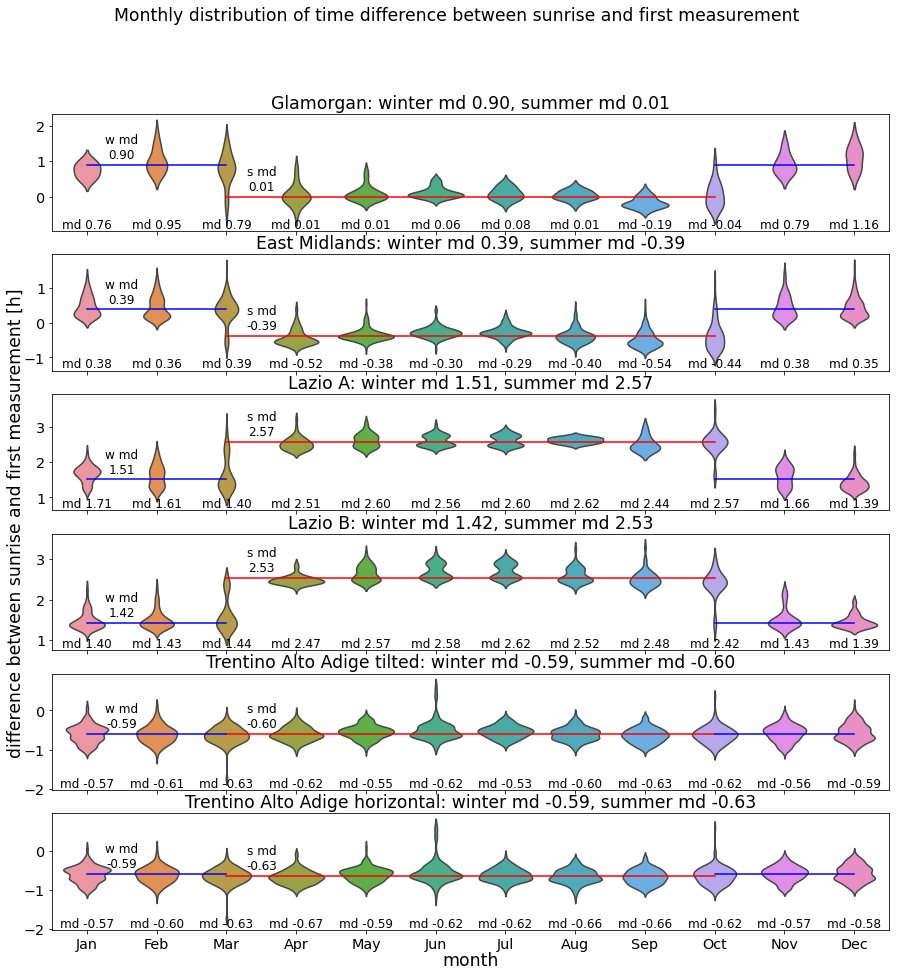

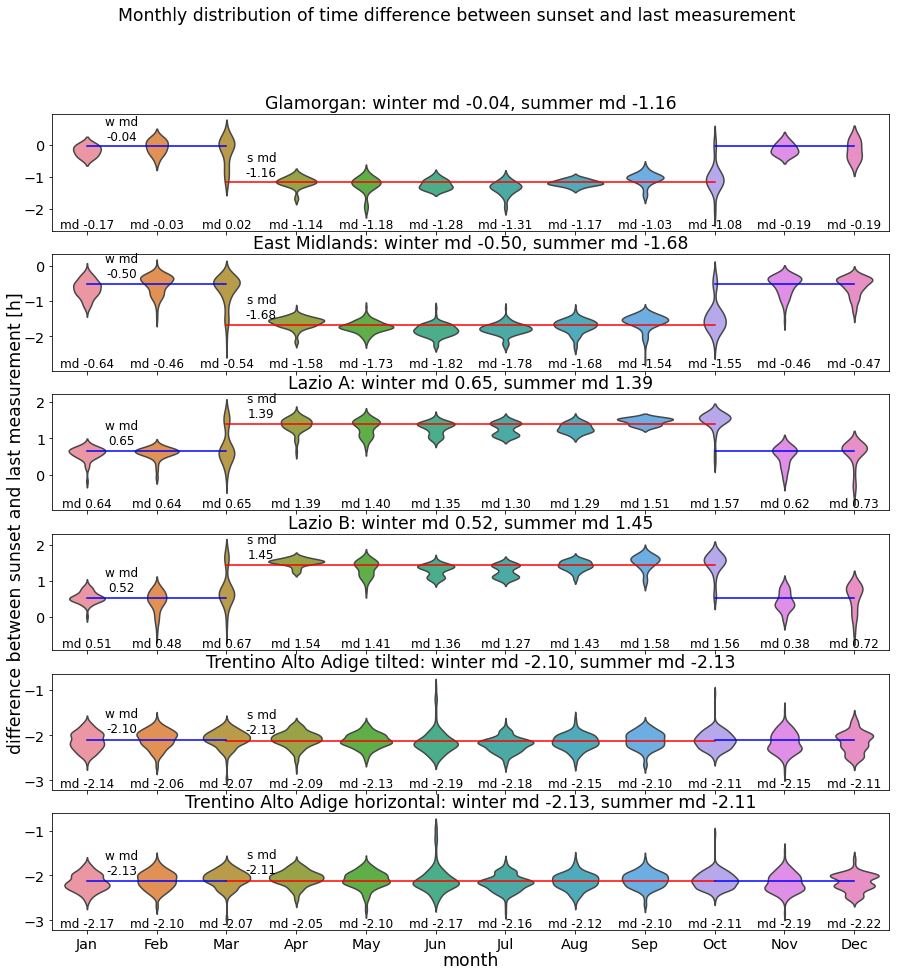

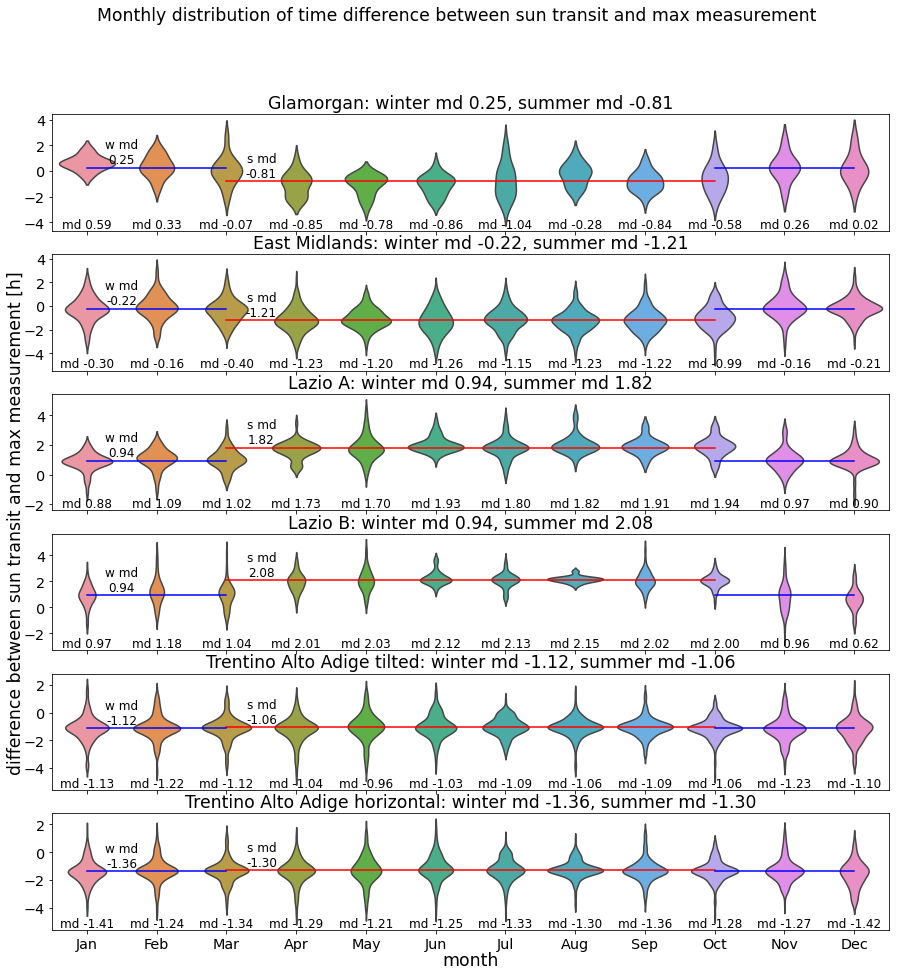

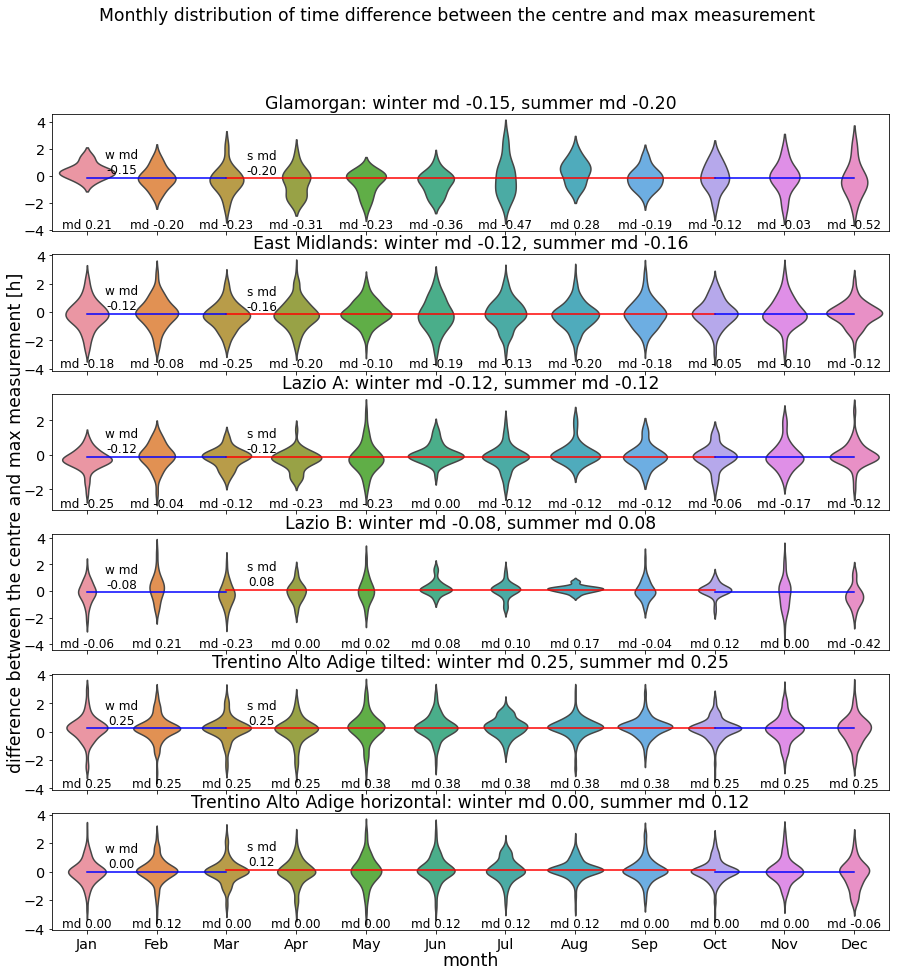

In [154]:
#re-merge for overall analysis
tz_mrg_cmps = [pd.concat([w, s], sort=True) for w, s in tz_cmps]
plot_monthly_delays(cmps=tz_mrg_cmps, labels=labels, sl_tzs=tzs)

In [155]:
#evalution DST splitted  assuming utc datetetimes
utc_cmps, dsc_utc = get_delays_overview(dfcs, ['utc']*6, sls, labels)
dsc_utc

Started 'get_delays_overview' at 2021-05-20 08:16:42.597214
Finished 'get_delays_overview' in 0:00:29.366093 secs


,delay_first_h_w,delay_last_h_w,delay_transit_h_w,delay_centre_h_w,delay_first_h_s,delay_last_h_s,delay_transit_h_s,delay_centre_h_s
Glamorgan,1.007838,-0.164994,0.192906,-0.200000,0.903400,-0.038954,0.249969,-0.154167
East Midlands,0.612818,-0.680929,-0.189977,-0.158333,0.386428,-0.504155,-0.224355,-0.125000
Lazio A,4.565155,3.392607,3.816681,-0.125000,2.512759,1.645983,1.910476,-0.166667
Lazio B,4.532611,3.451057,4.084220,0.083333,2.415385,1.522430,1.917898,-0.083333
Trentino Alto Adige tilted,1.397906,-0.129894,0.939161,0.250000,0.406134,-1.101803,-0.124759,0.250000
Trentino Alto Adige horizontal,1.367264,-0.114343,0.700870,0.125000,0.408595,-1.131569,-0.357271,0.000000


Monthly distribution of time difference between sunrise and first measurement.jpg saved at C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\python_repositories\ground-based-solar-irradiance/outputs/figures/
Monthly distribution of time difference between sunset and last measurement.jpg saved at C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\python_repositories\ground-based-solar-irradiance/outputs/figures/
Monthly distribution of time difference between sun transit and max measurement.jpg saved at C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\python_repositories\ground-based-solar-irradiance/outputs/figures/
Monthly distribution of time difference between the centre and max measurement.jpg saved at C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\python_repositories\ground-based-solar-irradiance/outputs/figures/


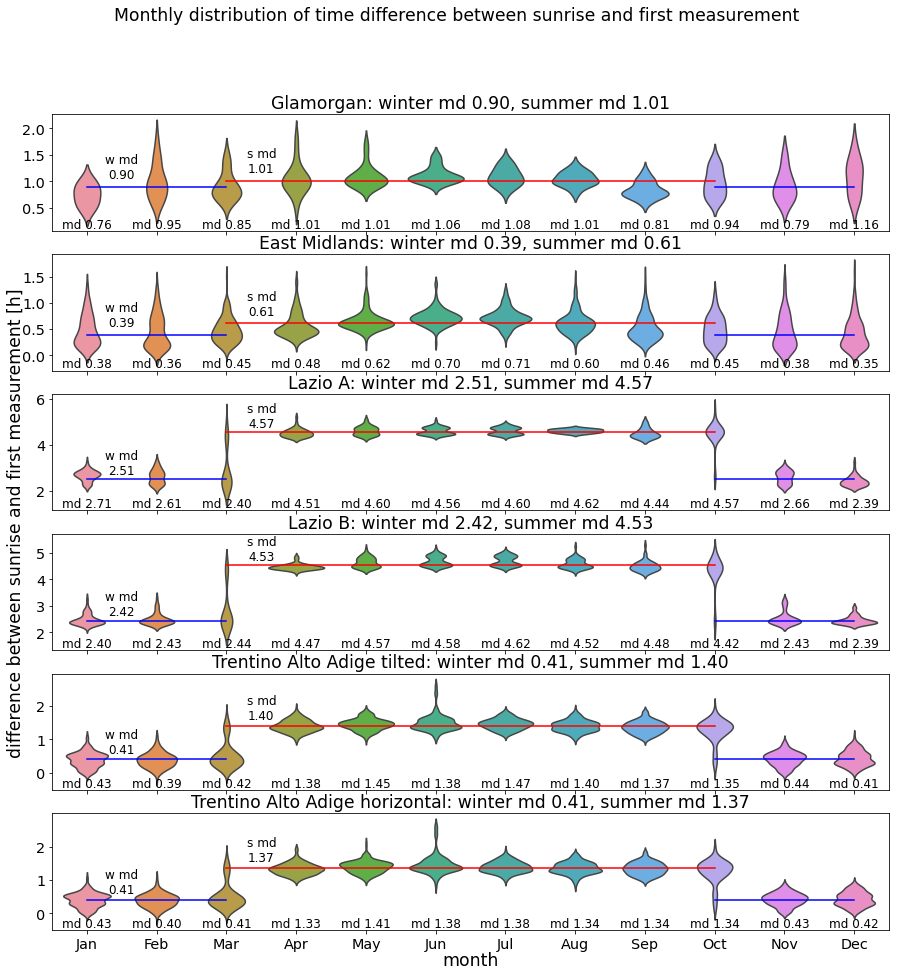

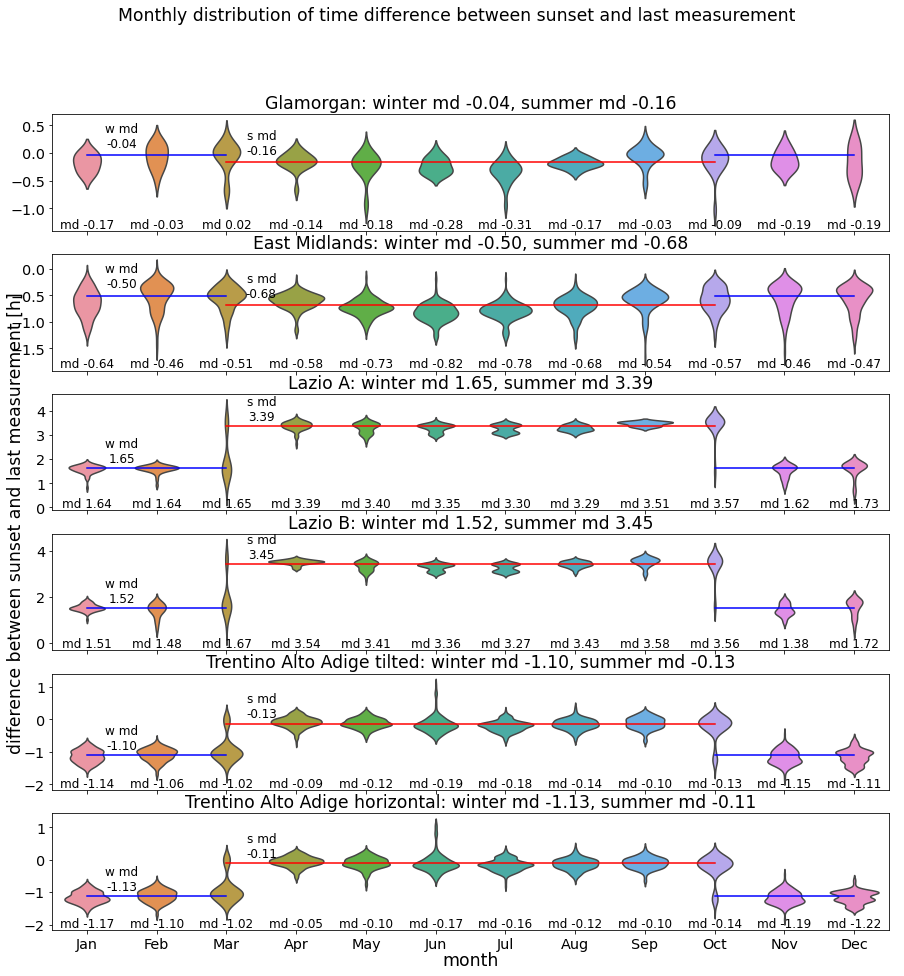

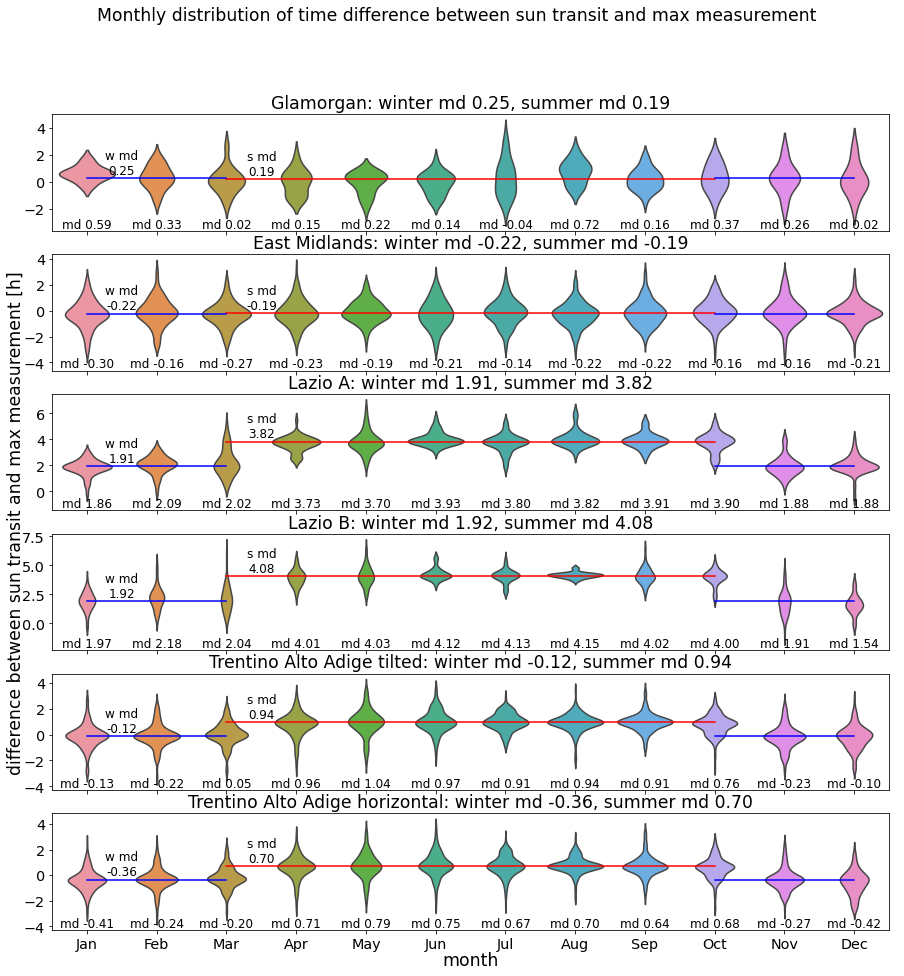

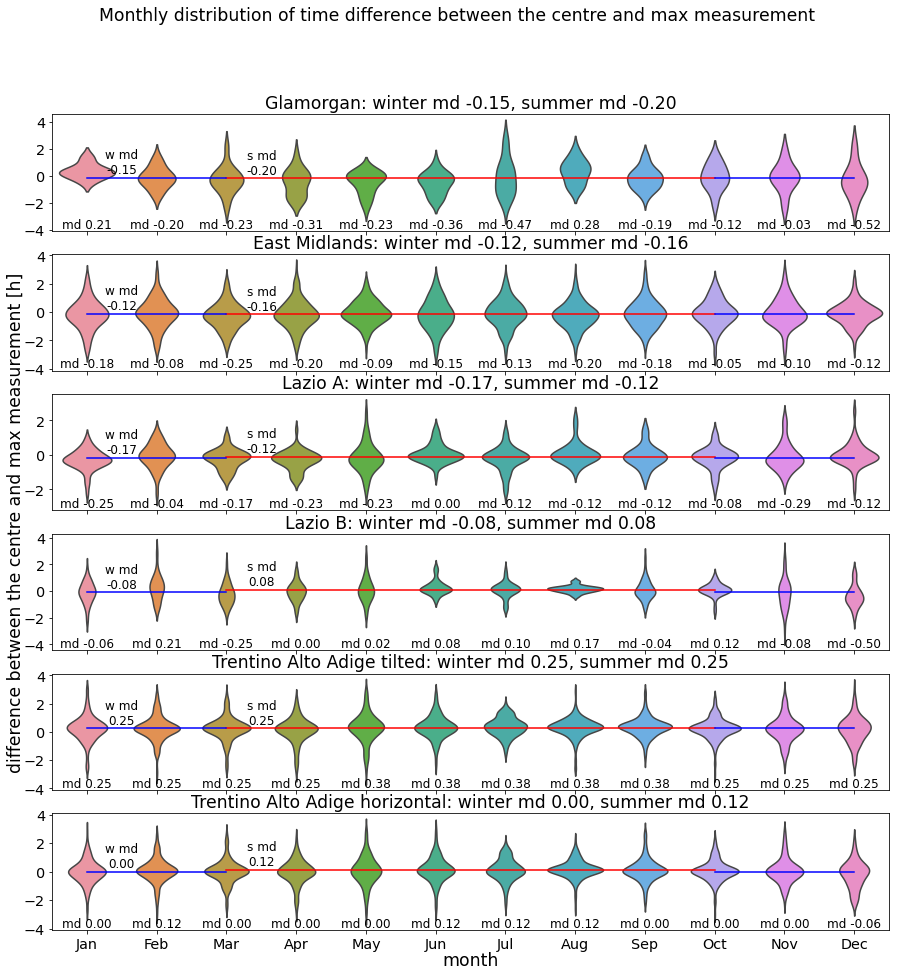

In [156]:
#re-merge for overall analysis
utc_mrg_cmps = [pd.concat([w, s], sort=True) for w, s in utc_cmps]
plot_monthly_delays(cmps=utc_mrg_cmps, labels=labels, sl_tzs=tzs, parameters=DELAY_PARAMETERS)

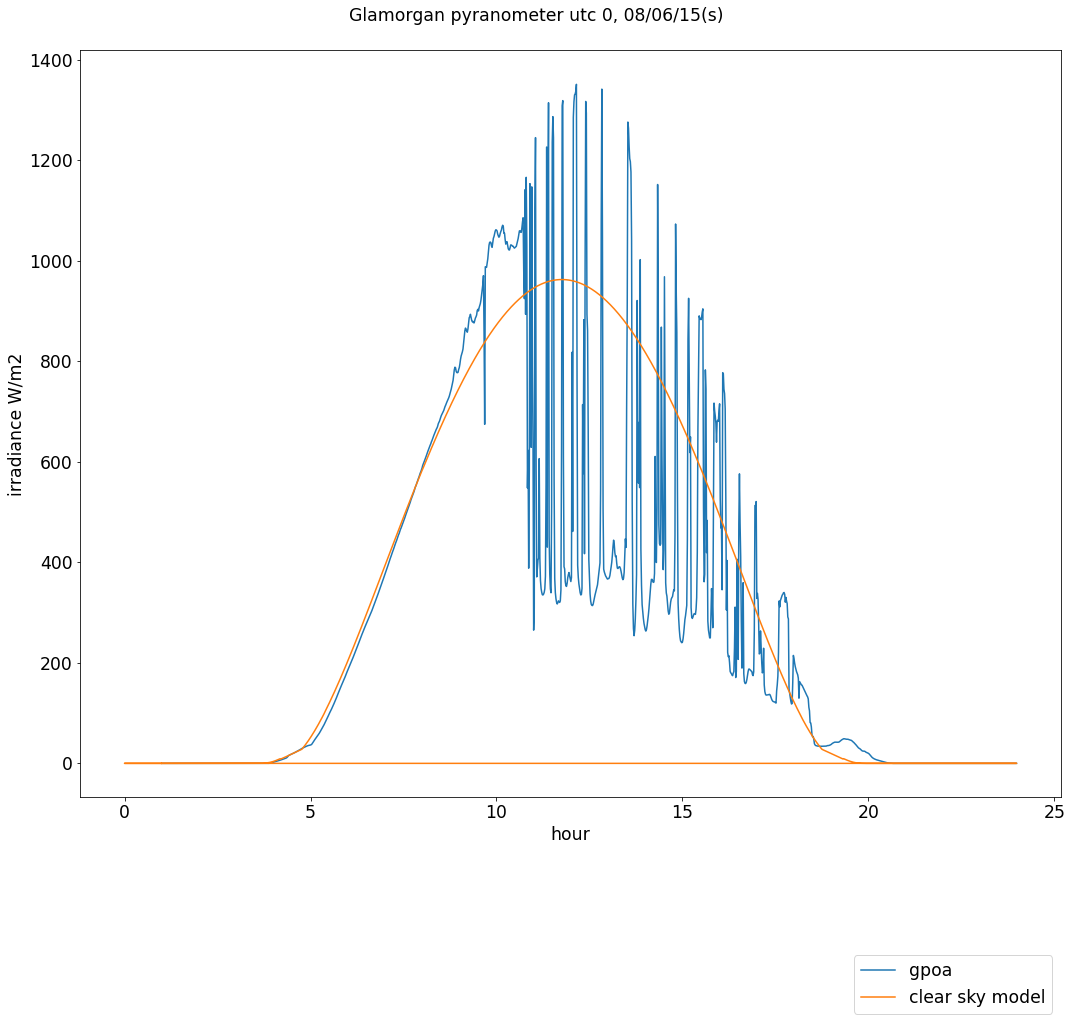

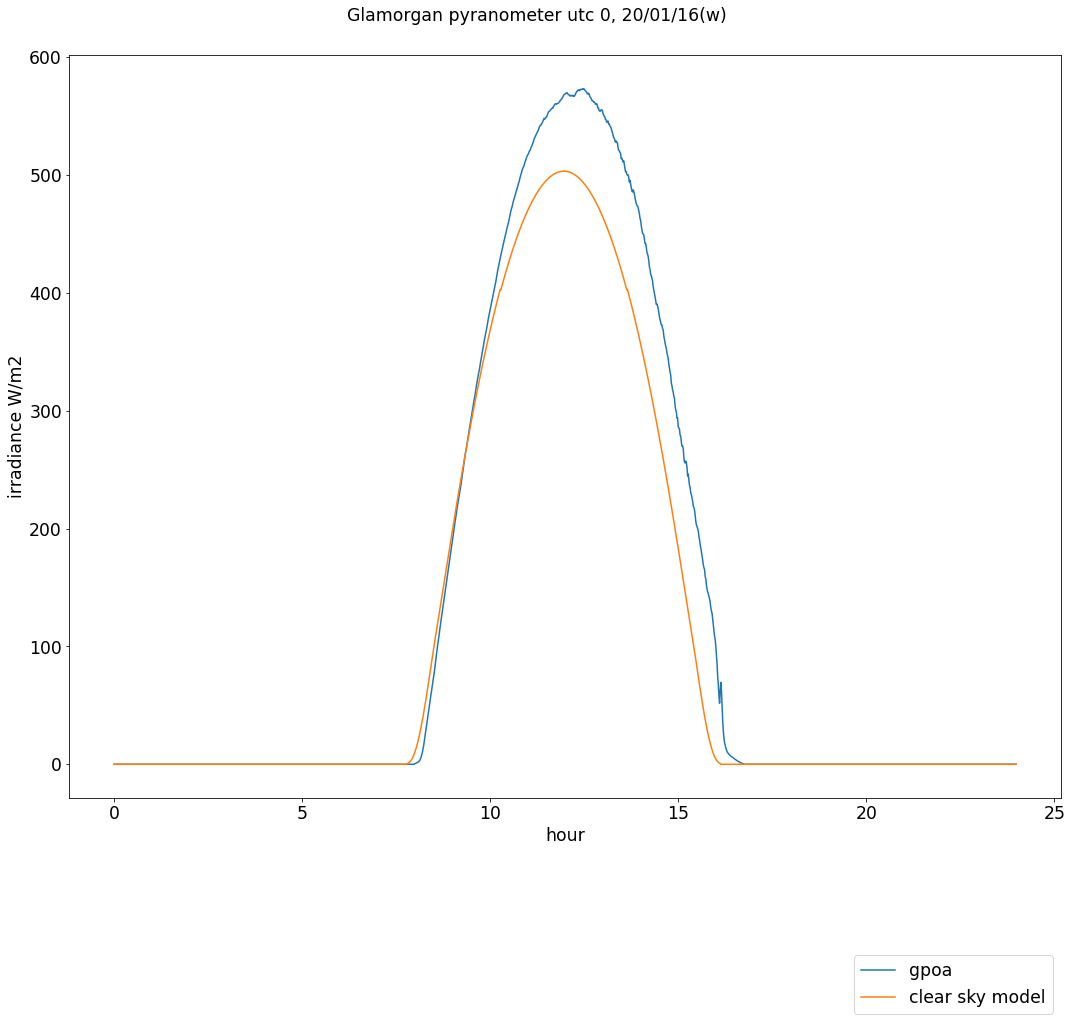

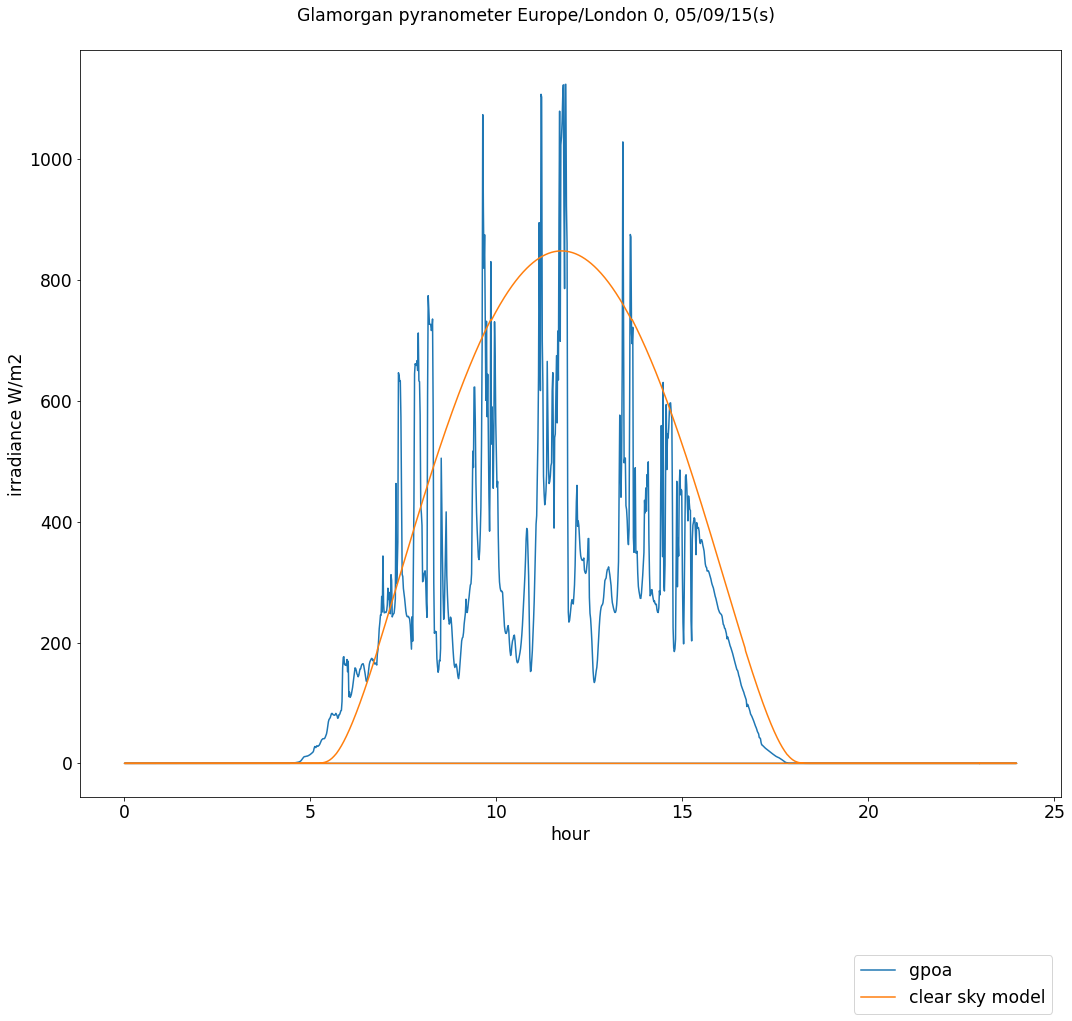

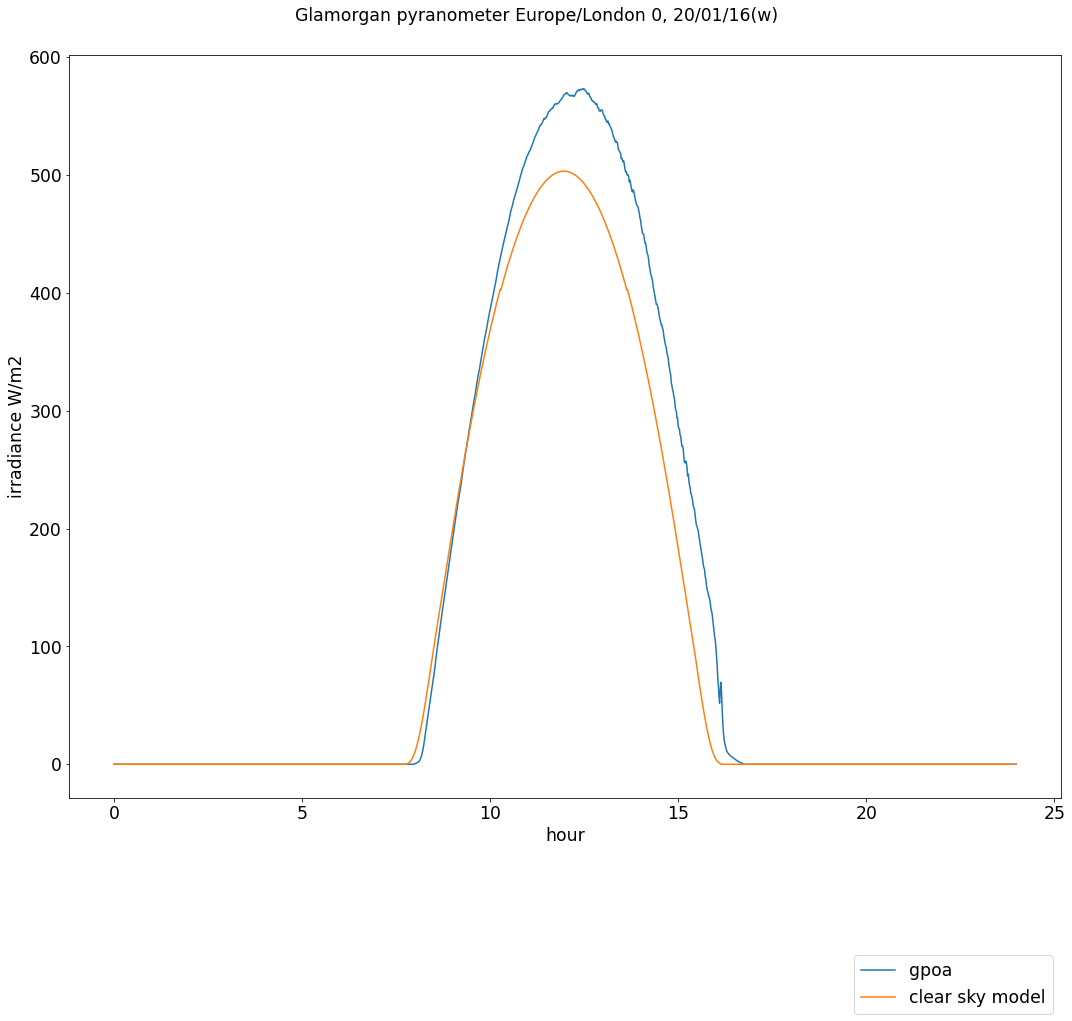

In [113]:
delayss = plot_daily_delays_overview(tz_mrg_cmps[:1], dfcs[:1], tzs[:1], sls[:1], labels[:1])

to be tested with cs
